In [1]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks

#do not rerun
h.load_file('stdrun.hoc')
h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","x86_64",".libs","libnrnmech.so"))
fileList = ['class_pyramidalcell.hoc','class_axoaxoniccell.hoc', 'class_pvbasketcell.hoc', 'class_olmcell.hoc']
for item in fileList:
    h.load_file(os.path.join("biophys_components","templates",item))
callNames = ["h." + fileList[i].split('_')[1].split('.')[0] + "()" for i in range(len(fileList))]
callNames.sort()

In [202]:
def getSynName(paramsDict):# so you don't have to track it down in the synapses.py file
    '''
    assumes file w/ synapses is called 'synapses.py' and is in the root directory
    assumes paramsDict has filename of the .json
    assumes the synapse is initialized as the variable 'lsyn' for example:
    lsyn = h.pyr2int(blablablah) 
    
    '''
    if type(paramsDict) == dict:
        fileName = paramsDict['filename']
    else:
        fileName = paramsDict
        
    fp = open(os.path.join("biophys_components","synaptic_models",fileName))
    data =json.load(fp)
    
    with open('synapses.py') as f:
        for i,item in enumerate(f):
            if ('add_synapse_model' in item) & (data['level_of_detail'] in item):
                funcName = item.split('add_synapse_model')[1].split('(')[1].split(',')[0]#very specific to how synapses.py is organized. not recommended)

    with open('synapses.py') as f:
        found = 0
        decLine = ''
        for i, item in enumerate(f):
            if 'def '+funcName in item:
                found = 1
                
            if (found == 1) & ('lsyn' in item):
                decLine = item
                found = 0 #only want the one
        synName = decLine.split('h.')[1].split('(')[0]
    return synName

In [3]:
def getSyn_vars(fileName,sectionName,key_str):
    '''
    takes json name, the mod file section heading name, and the string you want to search in it.
    i.e., to get all the synaptic conductances' variable names:
    getSyn_vars('PN2CHN.json','RANGE','gbar')
    returns
    ['gbar_nmda', 'gbar_ampa']
    for a mod file with nmda and ampa, for example an E->I synapse
    
    or to get all the synaptic current variable names:
    getSyn_vars('PN2CHN.json','NONSPECIFIC_CURRENT','i')
    
    '''
    
    modFile = getSynName(fileName)+'.mod'
    with open(os.path.join('biophys_components','mechanisms','modfiles',modFile)) as f:
        modDat = f.read()

    test_str = modDat
    test_sub = sectionName

    res = [i for i in range(len(test_str)) if test_str.startswith(test_sub, i)]

    varList = []
    for i in range(len(res)):
        substring = modDat[res[i]:]
        substring = substring[:substring.find('\n')]
        for item in substring.split(' '):
            if key_str in item:
                varList.append(item)
    #remove spaces and ',' or really just anything that is not alnum or underscore. so depends on user convention
    for i in range(len(varList)):
        string = varList[i]
        newStr = []
        for char in string:
            if char.isalnum() or (char == '_'):
                newStr.append(char)
        varList[i] = "".join(newStr)
    varList

    return varList

In [4]:
def run2cellModel(paramsDict):
    #read and close the json
    f = open(os.path.join("biophys_components","synaptic_models",paramsDict['filename']))
    data =json.load(f) 

    #make the cells, iclamp, synapse,and netcon and set their attributes
    Cell1 = eval(paramsDict['cell1'])# Pyr
    Cell2 = eval(paramsDict['cell2']) # AAC    
    
    iclamp = h.IClamp(Cell1.soma[0](0.5))
    [setattr(iclamp,key,float(paramsDict['IclampParams'][key])) for key in paramsDict['IclampParams'].keys() if hasattr(iclamp,key)]

    synParams = paramsDict['synTargetParams']
    syn = eval(f"h.{getSynName(paramsDict)}(Cell2.{synParams['secName']}[{synParams['secNo']}]({synParams['segNo']}))")
    [setattr(syn,key,float(data[key])) for key in data.keys() if hasattr(syn,key)]
    
    #pick a param to change
    [setattr(syn,key,float(paramsDict['gSyn'][key])) for key in paramsDict['gSyn'].keys() if float(paramsDict['gSyn'][key]) != -1]
    #also make into list so it can be easily switched between sims
    #syn.gbar_nmda = paramsDict['syn.gbar_nmda']
    #syn.gbar_ampa = paramsDict['syn.gbar_ampa']

    #assumes netCon is watching the soma of cell1 to decide if there is an event
    netcon = h.NetCon(Cell1.soma[0](0.5)._ref_v, syn,-10, 0, 1,sec=Cell1.soma[0])
 
    recVars = [h.Vector().record(Cell1.soma[0](0.5)._ref_v),h.Vector().record(Cell2.soma[0](0.5)._ref_v)]# somas
    synCurrentList = getSyn_vars(paramsDict['filename'],'NONSPECIFIC_CURRENT','i')
    for current in synCurrentList:
        recVars.append(h.Vector().record(eval(f"syn._ref_{current}")))
        
    tstop = paramsDict['simParams']['tstop']
    h.dt=paramsDict['simParams']['h.dt']
    h.L = paramsDict['simParams']['h.L']
    h.finitialize(paramsDict['simParams']['vinit'])
    h.continuerun(tstop)

    recVars = [np.array(recVar) for recVar in recVars]
    time = np.linspace(0,tstop,int(tstop/h.dt )+1)#+1 for some reason
    ICLAMP = np.zeros(len(time))
    ICLAMP[int(iclamp.delay/h.dt):int(iclamp.delay/h.dt+iclamp.dur)] = iclamp.amp
    recVars.append(ICLAMP)
    return time,recVars


In [ ]:
paramsDict = {'filename'        : 'PN2CHN.json',
              'cell1'           : 'h.pyramidalcell()',#cell that is stimulated w/ iclamp
              'cell2'           : 'h.axoaxoniccell()',
              
              'simParams'       : {'tstop': 300,
                                   'h.dt' : 0.1,
                                   'h.L'  : 20,
                                   'vinit': -63,
                                  },
              
              'IclampParams'    : {'delay' : 100,
                                   'dur'   : 8,
                                   'amp'   : 0.6,
                                  },
              
              'gSyn'            : {'gbar_nmda': -1,
                                   'gbar_ampa': -1                                   
                                  },

              
              'synTargetParams' :{'secName' : 'dend',
                                  'secNo'   : '6',
                                  'segNo'   : '0.5'
              
             }
             }

In [5]:
callNames

['h.axoaxoniccell()', 'h.olmcell()', 'h.pvbasketcell()', 'h.pyramidalcell()']

In [28]:
getSyn_vars('OLM2PN.json','RANGE','gbar')

['gbar_gaba']

In [56]:
getSynName('OLM2PN.json')

'int2pyr'

In [ ]:
# conn1 = setEdges(net,'AAC','Pyr',[ 0.072,     400],'CHN2PN.json', [1,            1.1 ],'axon', 6, 0.5)
# conn2 = setEdges(net,'Pyr','AAC',[ 0.009635,  400],'PN2CHN.json', [0.0,        400.0],'apical', 6, 0.5)
# conn3 = setEdges(net,'PV','Pyr', [ 0.05366,   400],'PV2PN.json',  [0.0,        400.0],'somatic',0, 0.5)
# conn4 = setEdges(net,'Pyr','PV', [ 0.0238,    400],'PN2PV.json',  [0.0,        400.0],'apical', 6, 0.5)
# conn5 = setEdges(net,'PV','AAC', [ 0.135,     400],'PV2CHN.json', [0.0,        400.0],'somatic',0, 0.5)
# conn6 = setEdges(net,'PV','PV',  [ 0.135,     400],'PV2PV.json',  [0.0,        400.0],'somatic',0, 0.5)
# conn7 = setEdges(net,'OLM','Pyr',[ 0.08300,   400],'OLM2PN.json', [0.0,        400.0],'apical', 4, 0.5)
# conn8 = setEdges(net,'OLM','AAC',[ 0.0800,    400],'OLM2CHN.json',[0.0,        400.0],'apical', 4, 0.5)
# conn9 = setEdges(net,'OLM','PV', [ 0.0800,    400],'OLM2PV.json', [0.0,        400.0],'apical', 4, 0.5)
# conn10 = setEdges(net,'OLM','OLM',[ 0.0800,    400],'OLM2OLM.json',[0.0,        400.0],'basal',  0, 0.9)
# conn11 = setEdges(net,'Pyr','OLM',[  0.1320,   400],'PN2OLM.json',[0.0,        400.0],'basal',  2, 0.5)

In [199]:
keyName = 'PV2PV_mp'
callNamesmapped = ['CHN', 'OLM','PV','PN']
Combos = {keyName: {'filename'        : f"{keyName.split('_')[0]}.json",
              'cell1'           : callNames[callNamesmapped.index(keyName.split('2')[0].split('_')[0])],#cell that is stimulated w/ iclamp
              'cell2'           : callNames[callNamesmapped.index(keyName.split('2')[1].split('_')[0])],
              
              'simParams'       : {'tstop': 300,
                                   'h.dt' : 0.1,
                                   'h.L'  : 20,
                                   'vinit': -63,
                                  },
              
              'IclampParams'    : {'delay' : 100,
                                   'dur'   : 8,
                                   'amp'   : 0.7,
                                  },
              
              'gSyn'            : {'gbar_gaba': -1
                                  },

              
              'synTargetParams' :{'secName' : 'soma',
                                  'secNo'   : '0',
                                  'segNo'   : '0.5'
                                 }
             }
         }

In [200]:

time,recVars = run2cellModel(Combos[keyName])


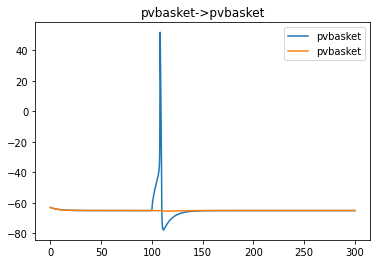

In [201]:

cell1str = Combos[keyName]['cell1'].split('h.')[1].split('cell')[0]
cell2str = Combos[keyName]['cell2'].split('h.')[1].split('cell')[0]
plt.plot(time,recVars[0],label = cell1str)
plt.plot(time,recVars[1],label = cell2str)
plt.title(f"{cell1str}->{cell2str}")
plt.legend()
plt.show()

In [187]:
with open(os.path.join('twocellmodelParams',f"{keyName}.json"), 'w') as outfile:
    json.dump(Combos[keyName], outfile)

# Basic

In [162]:
OLM = h.olmcell()
Pyr = h.pyramidalcell()

#Pyr.soma[0].gmax_ch_HCNp = 0

iclamp = h.IClamp(OLM.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 15
iclamp.amp = 0.6


vPyr = h.Vector().record(Pyr.soma[0](0.5)._ref_v)
vOLM = h.Vector().record(OLM.soma[0](0.5)._ref_v)



syn = h.chn2pyr(Pyr.soma[0](0.5))
syn.AlphaTmax_gaba = 1.52
syn.Beta_gaba = 0.14
syn.Cdur_gaba=0.7254
syn.gbar_gaba=0.001
syn.Erev_gaba=-70
syn.initW=100
syn.Wmax=25
syn.Wmin=0.25
syn.on_gaba  = 1
syn.r_gaba  = 1
syn.lambda1=1
syn.lambda2=0.01
syn.threshold1=0.5
syn.threshold2=0.6
syn.tauD1=40
syn.d1=0.95
syn.tauD2=70
syn.d2=0.9
syn.tauF=20
syn.f=10

iGABA = h.Vector().record(syn._ref_igaba)

netcon = h.NetCon(OLM.soma[0](0.5)._ref_v, syn,-10, 0, 1,sec=OLM.soma[0])

h.dt=0.1
h.L = 20
h.finitialize(-63)
h.continuerun(300)

vPyr = np.array(vPyr)
vOLM = np.array(vOLM)
plt.plot(time,vOLM,label='OLM')
plt.plot(time,vPyr ,label='Pyr ')
plt.legend()
plt.plot(iGABA)

# automated

In [ ]:
#look at amps of all cells, and 'rheoweight'

In [188]:
fileNames = os.listdir("twocellmodelParams")
fileNames = [fileName for fileName in fileNames if fileName.find('json') != -1]
resDict = {}
for fileName in fileNames:
    fp = open(os.path.join("twocellmodelParams",fileName))
    dictionary =json.load(fp)
    time,recVars = run2cellModel(dictionary)
    keyName = fileName.split('_')[0]
    resDict.update({keyName: recVars})
    

In [ ]:
plot.legend(loc=2, prop={'size': 6})

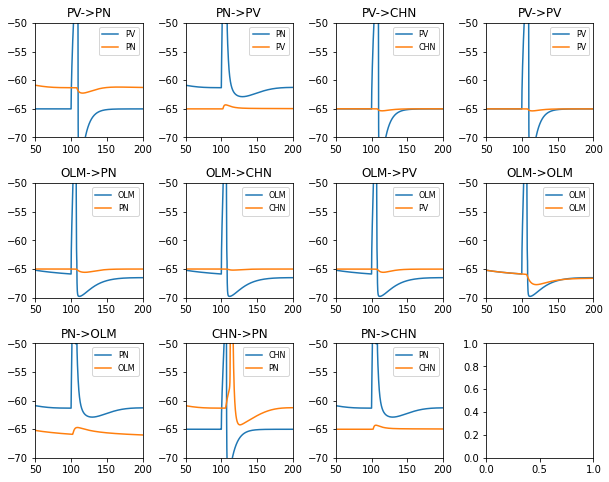

In [197]:
squareDim = int(len(fileNames)**.5)
r,c = 3,4
fig, axs = plt.subplots(r,c,figsize=(10,8))
keyCounter = 0
for i in range(r):
    for j in range(c):
        if (keyCounter) >= len(fileNames):
            break
        keyName = list(resDict.keys())[keyCounter]
        cell1str = keyName.split('2')[0]
        cell2str = keyName.split('2')[1]
        axs[i][j].plot(time,resDict[keyName][0],label = cell1str)
        axs[i][j].plot(time,resDict[keyName][1],label = cell2str)
        axs[i][j].set_title(f"{cell1str}->{cell2str}")
        axs[i][j].set_xlim([50,200])
        axs[i][j].set_ylim([-70,-50])
        axs[i][j].legend(prop = {'size':8})
        keyCounter+=1
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.show()

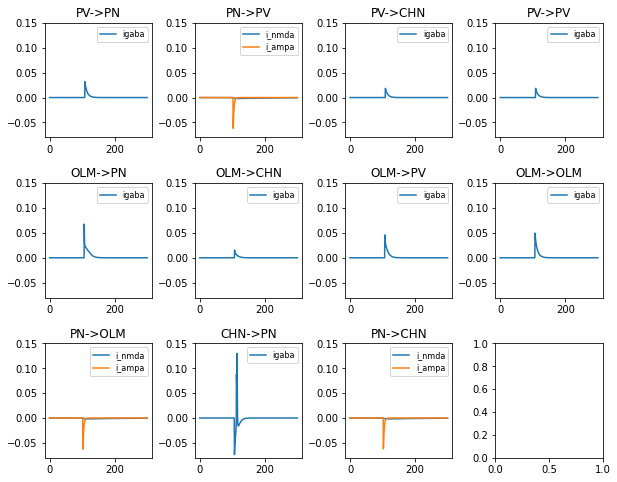

In [221]:
squareDim = int(len(fileNames)**.5)
r,c = 3,4
fig, axs = plt.subplots(r,c,figsize=(10,8))
keyCounter = 0
for i in range(r):
    for j in range(c):
        if (keyCounter) >= len(fileNames):
            break
        keyName = list(resDict.keys())[keyCounter]
        currentNames = getSyn_vars(f"{keyName}.json",'NONSPECIFIC_CURRENT','i')
        curr1str = currentNames[0]
        axs[i][j].plot(time,resDict[keyName][2],label = curr1str)
        if len(currentNames) == 2:#only ever 1 or 2 so not generic here
            curr2str = currentNames[1]
            axs[i][j].plot(time,resDict[keyName][3],label = curr2str)
        
        cell1str = keyName.split('2')[0]
        cell2str = keyName.split('2')[1]
        axs[i][j].set_title(f"{cell1str}->{cell2str}")
        #axs[i][j].set_xlim([50,200])
        axs[i][j].set_ylim([-0.08,0.15])
        axs[i][j].legend(prop = {'size':8})
        keyCounter+=1
plt.subplots_adjust(wspace=0.4,hspace=0.4)
plt.show()
    

# 'rheoweight'

# synaptic distribution

# Q's

In [ ]:
#how to check/set the threshold of the netcon object used in bmtk